In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
import pint_pandas
from metpy import constants
from scipy import interpolate
np.set_printoptions(suppress=True,precision=10)

# Parameters for calculations

In [ ]:
heights = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20

# Prepare data

## Open SOS Measurement Dataset

In [ ]:
start_date = '20221130'
end_date = '20230509'
# open files
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

## Add combined blowing snow flux variable
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue', 'snow flux', 1, 'ue',
)

## Add absolute humidity measurements by converting hygrometer measurements

In [ ]:
tower_height_keys = tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height']).indices.keys()
for t, h in tower_height_keys:
    this_tower_height_tidy_df = tidy_df.query(
            f"tower == '{t}'"
        ).query(
            f"height == {h}"
        )
    specific_humidity_values = this_tower_height_tidy_df.query(
            "measurement == 'specific humidity'"
        ).set_index('time')[['value']].rename(columns={'value': 'specific humidity'})
    air_density_values = this_tower_height_tidy_df.query(
            "measurement == 'air density'"
        ).set_index('time')[['value']].rename(columns={'value': 'air density'})
    combined_df = specific_humidity_values.join(air_density_values)

    abs_humidity_values = (
        combined_df['specific humidity'].values * units('g/g')
    ).to('g/kg') * (
        combined_df['air density'].values * units('kg/m^3')
    ).m

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        abs_humidity_values,
        f"absolutehumidity_{int(h)}m_{t}",
        'absolute humidity',
        int(h),
        t
    )

## Calibrate gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

In [ ]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [ ]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [ ]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

Update dataset with corrections

In [ ]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

In [ ]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

In [ ]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

In [ ]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [ ]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

In [ ]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
abs_hum = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Absolute humidity (g/m^3)").scale(zero=False),
    alt.Color("height:N"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600)

src = tidy_df[tidy_df.measurement=='snow depth']
snowdepth = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Snow depth (m)"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600, height=150)

(snowdepth & abs_hum).resolve_scale(color='independent', shape='independent')

# Identify categories for timestamps

In [ ]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

december_times = tidy_df[tidy_df.time.dt.month == 12].time
january_times = tidy_df[tidy_df.time.dt.month == 1].time
february_times = tidy_df[tidy_df.time.dt.month == 2].time
march_times = tidy_df[tidy_df.time.dt.month == 3].time
april_times = tidy_df[tidy_df.time.dt.month == 4].time

midwinter_times = tidy_df[tidy_df.time < '20230320'].time
spring_times = tidy_df[tidy_df.time > '20230320'].time

In [ ]:
precip_df = xr.open_dataset("/Users/elischwat/Development/data/sublimationofsnow/precip_danny/precipitation_rate_gts_w23.nc")['corrected_prcp_rate_m2'].to_dataframe()

is_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series() + dt.timedelta(minutes=30)
])
    
is_not_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series() + dt.timedelta(minutes=30)
])

# Create tables

## Instrument location info (georeferenced)
We use a file with theodolite/GPS readings provided by NCAR. 

In [ ]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

## Wind field measurements

In [ ]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin(heights)]
wind_field_df = round(wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
wind_field_df

## Turbulent water vapor flux measurements

In [ ]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin(heights)]
turb_flux_field_df = round(turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
turb_flux_field_df

## Humidity measurements

In [ ]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin(heights)]
abs_hum_field_df.measurement = 'q'
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

## Advective flux measurements

In [ ]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['uq'] = this_wind_df['u']*this_abs_hum_df['q']
        this_wind_df['vq'] = this_wind_df['v']*this_abs_hum_df['q']
        this_wind_df['wq'] = this_wind_df['w']*this_abs_hum_df['q']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new.drop(columns=[(h,t,'u'),(h,t,'v'),(h,t,'w')]))

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df.head()

# Divergence calculations

In [ ]:
def divergence(f,sp):
    """ 
    From: https://stackoverflow.com/a/67971515
    Computes divergence of vector field 
    f: array -> vector field components [Fx,Fy,Fz,...]
    sp: array -> spacing between points in respecitve directions [spx, spy,spz,...]
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], sp[i], axis=i) for i in range(num_dims)])

## Calculate interpolated fields

In [ ]:
# Initialize lists to store results
wind_fields = []
advectedflux_fields = []
abshumidity_fields = []
grid_spacings = []
turbulentflux_fields = []
timestamps = []

for i in wind_field_df.index:
    if ( # sometimes we don't have all measurements - this ensures we only retrieve data that exists
        (i in wind_field_df.index) and (i in adv_flux_field_df.index) and  
        (i in abs_hum_field_df.index) and  (i in turb_flux_field_df.index)
    ):
        # Isolate wind speed (u_i) measurements for this timestamp
        wind_field_vals = pd.DataFrame(
            wind_field_df.loc[i]
        ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
        wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
        
        # Isolate advective flux (u_i*q) measurements for this timestamp
        adv_flux_field_vals = pd.DataFrame(
            adv_flux_field_df.loc[i]
        ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
        adv_flux_field_vals.columns = adv_flux_field_vals.columns.droplevel(0)

        # Isolate humidity (q) measurements for this timestamp
        abs_humidity_field_vals = pd.DataFrame(
            abs_hum_field_df.loc[i]
        ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
        abs_humidity_field_vals.columns = abs_humidity_field_vals.columns.droplevel(0)

        # Isolate turbulent flux (u_i'q') measurements for this timestamp
        turb_flux_field_vals = pd.DataFrame(
            turb_flux_field_df.loc[i]
        ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
        turb_flux_field_vals.columns = turb_flux_field_vals.columns.droplevel(0)

        # Combine all measurements of fields and instrument locations into one dataframe
        points_and_fields = instrument_loc_df.join(
            wind_field_vals, how='right' # join on right df, so we drop instruments that we don't have measurements for
        ).join(
            adv_flux_field_vals,
        ).join(
            abs_humidity_field_vals,
        ).join(
            turb_flux_field_vals,
        ) 

        # Create a meshgrid for the interpolation
        xx, yy, zz = np.meshgrid(
            np.linspace(points_and_fields.x.min(), points_and_fields.x.max(), HORIZ_GRID_SPACING),
            np.linspace(points_and_fields.y.min(), points_and_fields.y.max(), HORIZ_GRID_SPACING),
            np.linspace(points_and_fields.z.min(), points_and_fields.z.max(), VERT_GRID_SPACING)
        )
        points = np.transpose(np.vstack((points_and_fields.x, points_and_fields.y, points_and_fields.z)))

        # Interpolate wind field
        u_interp = interpolate.griddata(points, points_and_fields['u'], (xx, yy, zz), method='linear')
        v_interp = interpolate.griddata(points, points_and_fields['v'], (xx, yy, zz), method='linear')
        w_interp = interpolate.griddata(points, points_and_fields['w'], (xx, yy, zz), method='linear')

        # Interpolate advected flux field
        uq_interp = interpolate.griddata(points, points_and_fields['uq'], (xx, yy, zz), method='linear')
        vq_interp = interpolate.griddata(points, points_and_fields['vq'], (xx, yy, zz), method='linear')
        wq_interp = interpolate.griddata(points, points_and_fields['wq'], (xx, yy, zz), method='linear')

        # Interpolate abs. humidity field
        q_interp = interpolate.griddata(points, points_and_fields['q'], (xx, yy, zz), method='linear')

        # Interpolate turbulent flux field
        u_q__interp = interpolate.griddata(points, points_and_fields['u_h2o_'], (xx, yy, zz), method='linear')
        v_q__interp = interpolate.griddata(points, points_and_fields['v_h2o_'], (xx, yy, zz), method='linear')
        w_q__interp = interpolate.griddata(points, points_and_fields['w_h2o_'], (xx, yy, zz), method='linear')

        # Combine interpolated components into vector fields
        F = np.array([u_interp, v_interp, w_interp])
        Fq = np.array([uq_interp, vq_interp, wq_interp])
        F_q_ = np.array([u_q__interp, v_q__interp, w_q__interp])

        # Record grid spacing        
        sp_x = np.diff(xx[0,:,0]).mean()
        sp_y = np.diff(yy[:,0,0]).mean()
        sp_z = np.diff(zz[0,0,:]).mean()
        sp = [sp_x, sp_y, sp_z]

        # Append interpolated fields to our results lists
        wind_fields.append(F)
        advectedflux_fields.append(Fq)
        abshumidity_fields.append(q_interp)
        turbulentflux_fields.append(F_q_)
        grid_spacings.append(sp)
        timestamps.append(i)

## Calculate divergences


In [69]:
# Initialize lists to store results
div_wind_field_ls = []
div_wind_field_lateral_ls = []
div_wind_field_vertical_ls = []
div_advectedflux_field_ls = []
div_turbulentflux_field_ls = []
div_turbulentflux_field_lateral_ls = []
div_turbulentflux_field_vertical_ls = []
div_abshumidity_field_ls = []
div_advectedflux_field_scalargradient_ls = []
div_advectedflux_field_windgradient_ls = []
div_advectedflux_field_windgradient_lateral_ls = []
div_advectedflux_field_windgradient_vertical_ls = []

# iterate over each field (timestamp) and calculate divergences
for i in range(0, len(wind_fields)):
    wind_field          = wind_fields[i]
    advectedflux_field  = advectedflux_fields[i]
    abshumidity_field   = abshumidity_fields[i]
    turbulentflux_field = turbulentflux_fields[i]
    grid_spacing        = grid_spacings[i]

    # create wind fields with just lateral and vertical components
    wind_field_vertical_only = wind_field.copy()
    wind_field_lateral_only  = wind_field.copy()
    wind_field_vertical_only[0] = 0
    wind_field_vertical_only[1] = 0
    wind_field_lateral_only[2] = 0

    turbulentflux_field_vertical_only = turbulentflux_field.copy()
    turbulentflux_field_lateral_only = turbulentflux_field.copy()
    turbulentflux_field_vertical_only[0] = 0
    turbulentflux_field_vertical_only[1] = 0
    turbulentflux_field_lateral_only[2] = 0

    # calculate divergences

    # For humidity field
    div_abshumidity_field    = np.gradient(
        abshumidity_field,  grid_spacing[0],    axis=0
    ) + np.gradient(
        abshumidity_field,  grid_spacing[1],    axis=1
    ) + np.gradient(
        abshumidity_field,  grid_spacing[2],    axis=2
    )

    # For wind field
    div_wind_field          = divergence(wind_field, grid_spacing)
    div_wind_field_lateral  = divergence(wind_field_lateral_only, grid_spacing)
    div_wind_field_vertical  = divergence(wind_field_vertical_only, grid_spacing)

    # For turbulent flux
    div_turbulentflux_field = divergence(turbulentflux_field, grid_spacing)
    div_turbulentflux_field_lateral = divergence(turbulentflux_field_lateral_only, grid_spacing)
    div_turbulentflux_field_vertical = divergence(turbulentflux_field_vertical_only, grid_spacing)

    # For advected flux of form: d/dx (u_i q)
    div_advectedflux_field  = divergence(advectedflux_field, grid_spacing)
    # For advected flux of form: u d/dx (q)
    div_advectedflux_field_scalargradient   = wind_field*div_abshumidity_field
    # For advected flux of form: q d/dx (u)
    div_advectedflux_field_windgradient         = abshumidity_field*div_wind_field
    div_advectedflux_field_windgradient_lateral = abshumidity_field*div_wind_field_lateral
    div_advectedflux_field_windgradient_vertical= abshumidity_field*div_wind_field_vertical

    div_wind_field_ls.append(
        div_wind_field
    )
    div_wind_field_lateral_ls.append(
        div_wind_field_lateral
    )
    div_wind_field_vertical_ls.append(
        div_wind_field_vertical
    )
    div_advectedflux_field_ls.append(
        div_advectedflux_field
    )
    div_turbulentflux_field_ls.append(
        div_turbulentflux_field
    )
    div_turbulentflux_field_lateral_ls.append(
        div_turbulentflux_field_lateral
    )
    div_turbulentflux_field_vertical_ls.append(
        div_turbulentflux_field_vertical
    )
    div_abshumidity_field_ls.append(
        div_abshumidity_field
    )
    div_advectedflux_field_scalargradient_ls.append(
        div_advectedflux_field_scalargradient
    )
    div_advectedflux_field_windgradient_ls.append(
        div_advectedflux_field_windgradient
    )
    div_advectedflux_field_windgradient_lateral_ls.append(
        div_advectedflux_field_windgradient_lateral
    )
    div_advectedflux_field_windgradient_vertical_ls.append(
        div_advectedflux_field_windgradient_vertical
    )

## Calculate spatially averaged divergence values

In [85]:
conservation_spatial_mean_df = pd.DataFrame({
    'wind_field' : [
        np.nanmean(item) for item in div_wind_field_ls
    ],
    'wind_field_lateral' : [
        np.nanmean(item) for item in div_wind_field_lateral_ls
    ],
    'wind_field_vertical' : [
        np.nanmean(item) for item in div_wind_field_vertical_ls
    ],
    'div_advectedflux_field' : [
        np.nanmean(item) for item in div_advectedflux_field_ls
    ],
    'div_turbulentflux_field' : [
        np.nanmean(item) for item in div_turbulentflux_field_ls
    ],
    'div_turbulentflux_field_lateral' : [
        np.nanmean(item) for item in div_turbulentflux_field_lateral_ls
    ],
    'div_turbulentflux_field_vertical' : [
        np.nanmean(item) for item in div_turbulentflux_field_vertical_ls
    ],
    'div_abshumidity_field' : [
        np.nanmean(item) for item in div_abshumidity_field_ls
    ],
    'div_advectedflux_field_scalargradient' : [
        np.nanmean(item) for item in div_advectedflux_field_scalargradient_ls
    ],
    'div_advectedflux_field_windgradient' : [
        np.nanmean(item) for item in div_advectedflux_field_windgradient_ls
    ],
    'div_advectedflux_field_windgradient_lateral' : [
        np.nanmean(item) for item in div_advectedflux_field_windgradient_lateral_ls
    ],
    'div_advectedflux_field_windgradient_vertical' : [
        np.nanmean(item) for item in div_advectedflux_field_windgradient_vertical_ls
    ],
}, index = timestamps)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/1270550530.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(item) for item in div_wind_field_ls
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/1270550530.py:6: RuntimeWarning: Mean of empty slice
  np.nanmean(item) for item in div_wind_field_lateral_ls
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/1270550530.py:9: RuntimeWarning: Mean of empty slice
  np.nanmean(item) for item in div_wind_field_vertical_ls
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/1270550530.py:12: RuntimeWarning: Mean of empty slice
  np.nanmean(item) for item in div_advectedflux_field_ls
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/1270550530.py:24: RuntimeWarning: Mean of empty slice
  np.nanmean(item) for item in div_abshumidity_field_ls
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/1270550530.py:27: RuntimeWarning: Mean of empty slice
  np.nanmean

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/903501817.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  conservation_spatial_mean_df.index.floor('30T').time


Text(0.5, 1.0, 'Advective divergences, 3 ways')

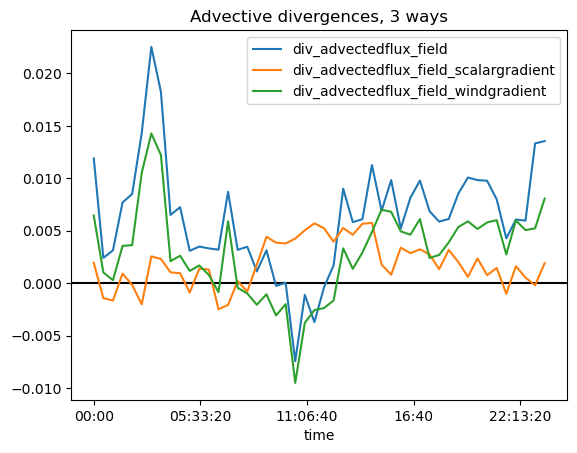

In [89]:
plt.axhline(0, color='k')
conservation_spatial_mean_df[[
    'div_advectedflux_field',
    'div_advectedflux_field_scalargradient',
    'div_advectedflux_field_windgradient'
]].groupby(
    conservation_spatial_mean_df.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective divergences, 3 ways")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/2962616717.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  conservation_spatial_mean_df.index.floor('30T').time


Text(0.5, 1.0, 'Advective divergence')

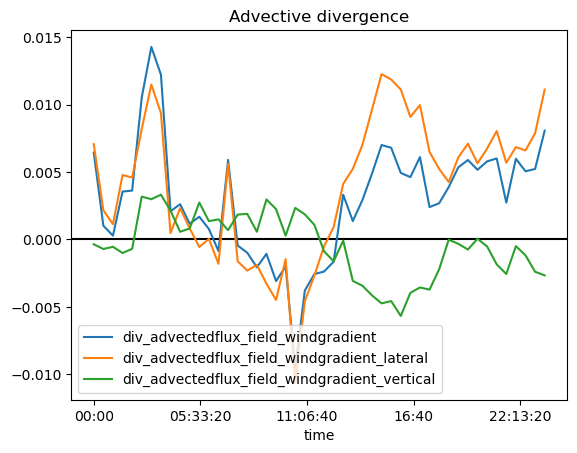

In [90]:
plt.axhline(0, color='k')
conservation_spatial_mean_df[[
    'div_advectedflux_field_windgradient',
    'div_advectedflux_field_windgradient_lateral',
    'div_advectedflux_field_windgradient_vertical',
]].groupby(
    conservation_spatial_mean_df.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective divergence")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/1731913438.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  conservation_spatial_mean_df.index.floor('30T').time


Text(0.5, 1.0, 'Turbulent divergence')

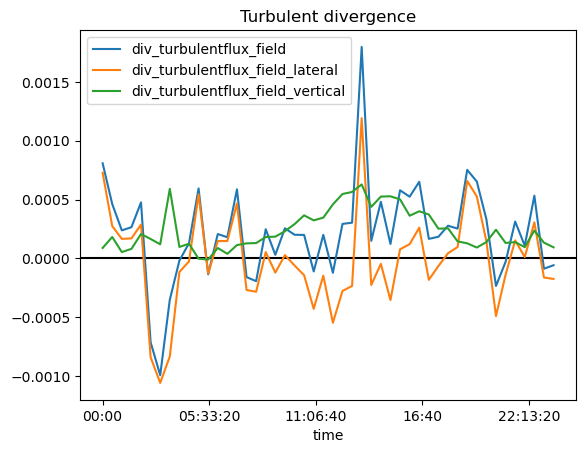

In [91]:
plt.axhline(0, color='k')
conservation_spatial_mean_df[[
    'div_turbulentflux_field',
    'div_turbulentflux_field_lateral',
    'div_turbulentflux_field_vertical',
]].groupby(
    conservation_spatial_mean_df.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Turbulent divergence")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/3908778584.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  conservation_spatial_mean_df.index.floor('30T').time


Text(0.5, 1.0, 'Advective and turbulent divergence')

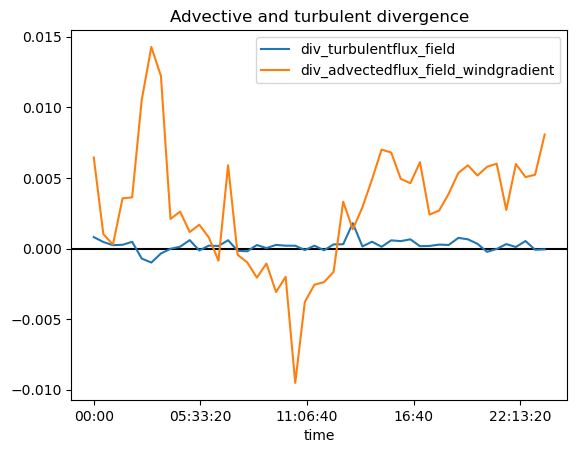

In [92]:
plt.axhline(0, color='k')
conservation_spatial_mean_df[[
    'div_turbulentflux_field',
    'div_advectedflux_field_windgradient'
]].groupby(
    conservation_spatial_mean_df.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective and turbulent divergence")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/4068248159.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src.index.floor('30T').time


Text(0.5, 1.0, 'Advective and turbulent divergence, not snowing or blowing')

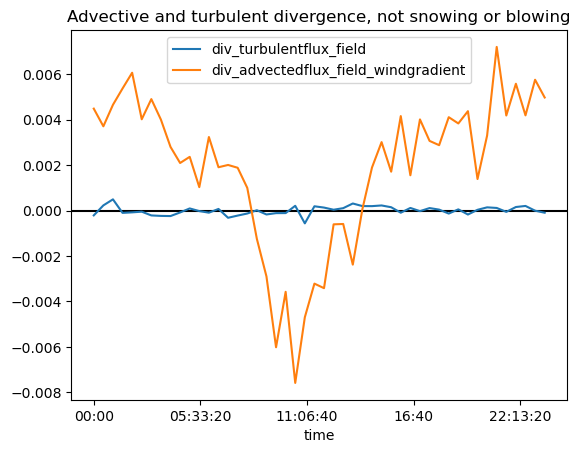

In [95]:
plt.axhline(0, color='k')
src = conservation_spatial_mean_df[
    conservation_spatial_mean_df.index.isin(nobs_times)
]
src = src[src.index.isin(is_not_snowing_dates)]
src[[
    'div_turbulentflux_field',
    'div_advectedflux_field_windgradient'
]].groupby(
    src.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective and turbulent divergence, not snowing or blowing")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/3159531664.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src.index.floor('30T').time


Text(0.5, 1.0, 'Advective and turbulent divergence, not snowing or blowing')

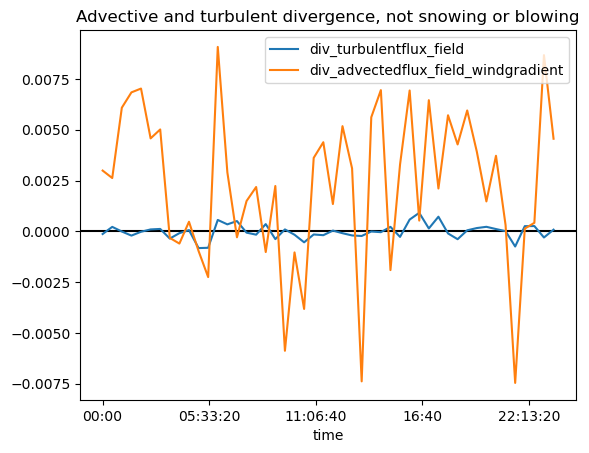

In [104]:
plt.axhline(0, color='k')
src = conservation_spatial_mean_df[
    conservation_spatial_mean_df.index.isin(nobs_times)
]
src = src[src.index.month == 12]
src[[
    'div_turbulentflux_field',
    'div_advectedflux_field_windgradient'
]].groupby(
    src.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective and turbulent divergence, not snowing or blowing")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_73613/2998626858.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src.index.floor('30T').time


Text(0.5, 1.0, 'Advective and turbulent divergence, not snowing or blowing')

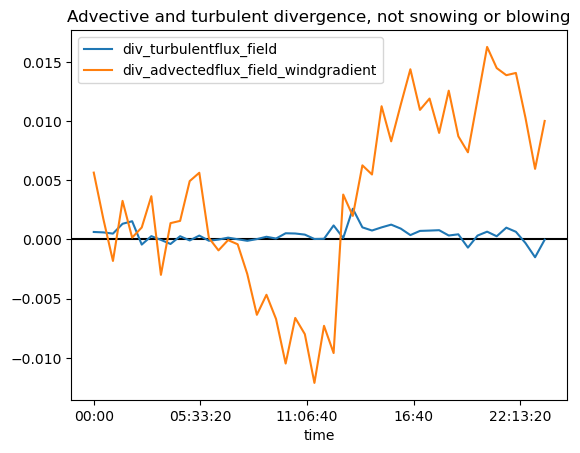

In [105]:
plt.axhline(0, color='k')
src = conservation_spatial_mean_df[
    conservation_spatial_mean_df.index.isin(nobs_times)
]
src = src[src.index.month == 4]
src[[
    'div_turbulentflux_field',
    'div_advectedflux_field_windgradient'
]].groupby(
    src.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective and turbulent divergence, not snowing or blowing")